# This notebook deals with temperature stuff for PMIP4 midHolocene paper.

### Import packages and define pmip generations and model lists

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF


In [4]:
#Define pimp generations and model names
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'INM-CM4-8',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  



## This part define the functions to find files fitting variable and experiment requirements.

In [6]:
#No change needs here
#This cell defines the functions to find variables, models and experiments



#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA/" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


## This part defines functions to calculate ensemble averages and SDs

In [ ]:
#No change needs here
#This cell defines the functions to calculate ensembel averages and averaged changes


#This function will calculate the ensemble average
def ensemble_mean(pmip_v,variable_name,experiment_name):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    ensemble_ave_r=np.zeros((180,360))
    for c in range(360):
        ensemble_ave_r[:,c]=average[:,c-180]            
    return ensemble_ave_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble average of the differences
def ensemble_mean_diffence(pmip_v,experiment_name,variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    ensemble_diff_r=np.zeros((180,360))
    for c in range(360):
        ensemble_diff_r[:,c]=average[:,c-180]
    return ensemble_diff_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble stddev of the differences
def ensemble_stddev(pmip_v,experiment_name,variable_name):
    model_list=[]
    dataset=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset.append(diff_1x1)
    data=np.array(dataset)
    std=np.std(data,axis=0)
    reverse=np.zeros((180,360))
    for c in range(360):
        reverse[:,c]=diff_1x1[:,c-180]   
    return reverse

In [5]:
#No change needs here

'''Define plotting functions'''
#This fuction will plot Robinson projected Geo2D map for averaged temperature in deg_C
def tas_ave_plot(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('coolwarm')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1.5,1.5]
    bounds = np.linspace(-1.5, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#Same as above but for uncertainty, i.e. stddev
def tas_std_plot(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlOrRd')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#This fuction will plot Robinson projected Geo2D map for averaged precipitation rate in mm/day
def pr_ave_plot(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1,1]
    bounds = np.linspace(-1, 1, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6 ')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#Same as above but for uncertainty, i.e. stddev
def pr_std_plot(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlGn')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#  Calculations - annual mean temperature

In [6]:
'''Set experiment and variable names'''
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'

'''calculations'''
#PMIP3
tas_ann_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
tas_ann_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

tas_ann_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
tas_ann_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
tas_ann_ensemble_diff=tas_ann_ensemble_ave_v4-tas_ann_ensemble_ave_v3




/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

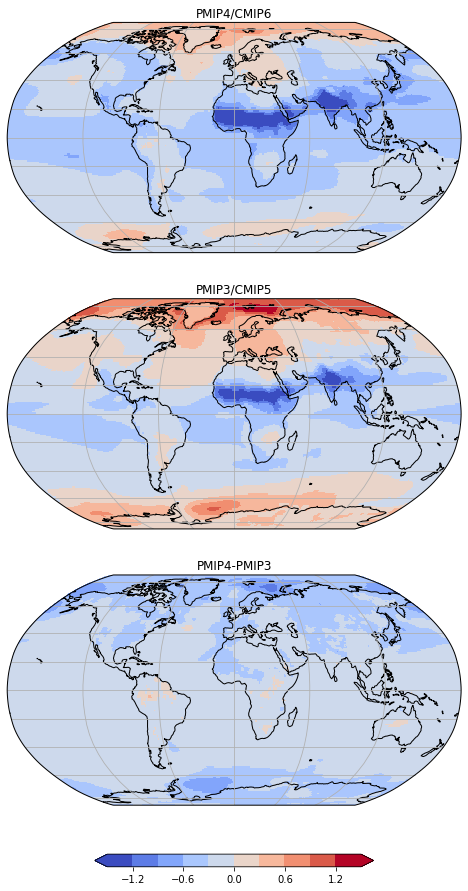

In [7]:
'''Annual mean temperature: ensemble average in deg_C, PMIP3 vs PMIP4.
Top two figures show the ensemble mean of changes (midHolocene minus piControl) in annual mean temperature in PMIP4 and PMIP3. 
The bottom one is the changes since PMIP3, it shows the difference between the top two figures.'''

tas_ave_plot(tas_ann_ensemble_ave_v4,tas_ann_ensemble_ave_v3,tas_ann_ensemble_diff,experiment_name,variable_name)

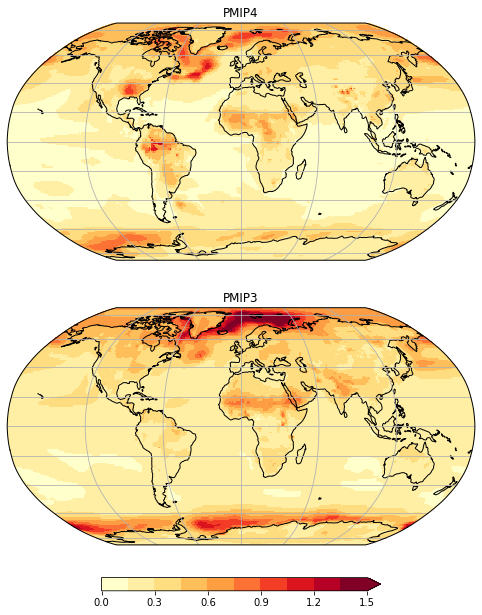

In [8]:
'''Annual mean temperature: ensemble uncertainty, PMIP3 vs PMIP4.
It shows the ensemble mean of standard deviation of changes (midHolocene minus piControl) in annual mean temperature in PMIP3. 
PMIP4 uncertainty is currently unavailable as we haven't got enough model data.'''

tas_std_plot(tas_ann_ensemble_std_v4,tas_ann_ensemble_std_v3,experiment_name,variable_name)

# 3. Calculations -- seasonal cycle of surface temp

## DJF mean temperature

In [10]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_djf'


'''calculations'''
#PMIP3
tas_djf_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
tas_djf_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

tas_djf_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
tas_djf_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
tas_djf_ensemble_diff=tas_djf_ensemble_ave_v4-tas_djf_ensemble_ave_v3





Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

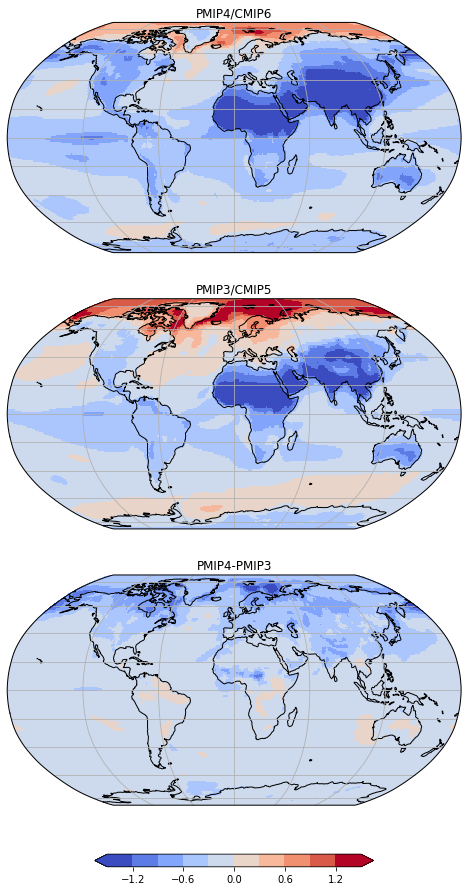

In [11]:
'''Changes in seasonal cycle of surface temp, DJF: ensemble average in◦C, PMIP3 vs PMIP4.
Top two figures show theensemble mean of changes (midHolocene-cal-adj minus piControl) in DJF mean temperature in PMIP4 and PMIP3. 
The bottom one is thechanges since PMIP3, it shows the difference between the top two figures.)'''

tas_ave_plot(tas_djf_ensemble_ave_v4,tas_djf_ensemble_ave_v3,tas_djf_ensemble_diff,experiment_name,variable_name)

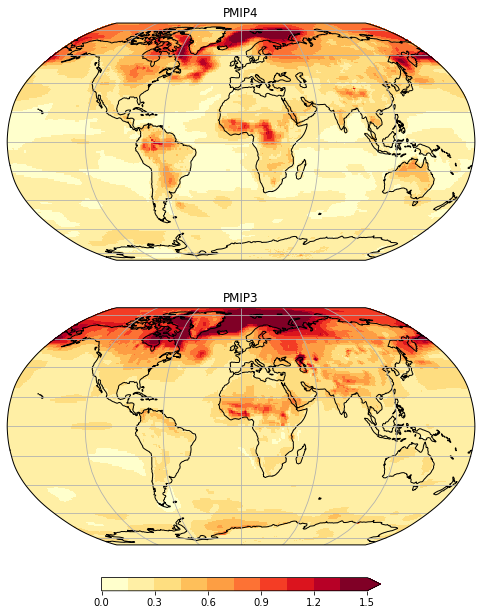

In [12]:
tas_std_plot(tas_djf_ensemble_std_v4,tas_djf_ensemble_std_v3,experiment_name,variable_name)

## JJA mean temperature

In [14]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_jja'

tas_jja_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
tas_jja_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

tas_jja_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
tas_jja_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
tas_jja_ensemble_diff=tas_jja_ensemble_ave_v4-tas_jja_ensemble_ave_v3







Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

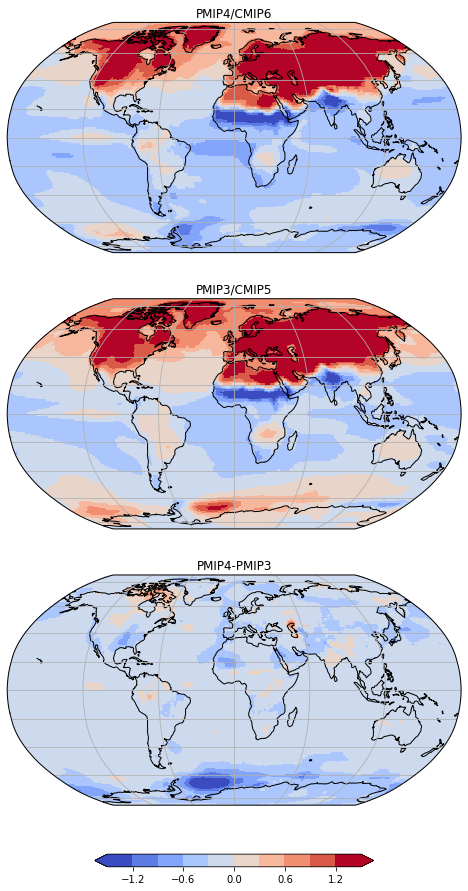

In [15]:
'''Same as DJF, but for JJA'''
tas_ave_plot(tas_jja_ensemble_ave_v4,tas_jja_ensemble_ave_v3,tas_jja_ensemble_diff,experiment_name,variable_name)

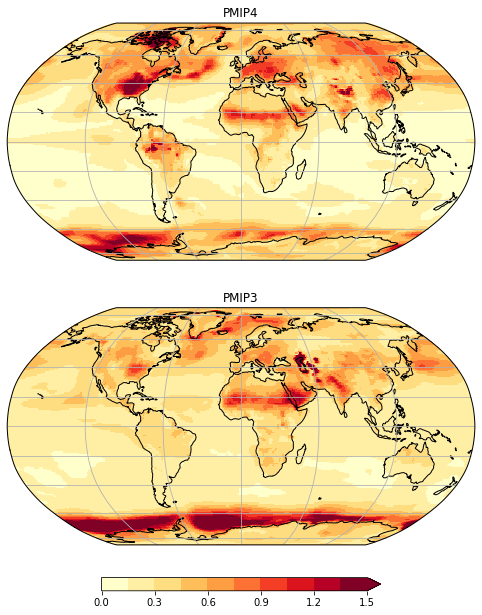

In [16]:
tas_std_plot(tas_jja_ensemble_std_v4,tas_jja_ensemble_std_v3,experiment_name,variable_name)

# Making temperature figures used in midHolocene paper

In [3]:
d=Dataset('plotting_data/estimated_forcing_tempchange.nc')

forcing=d.variables['forced_temp_change'][:]

d.close()

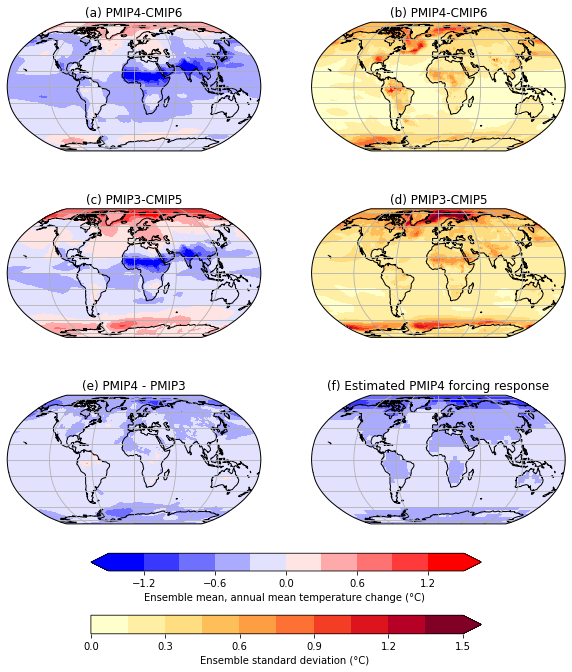

In [4]:
cmap1=plt.get_cmap('bwr')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim1=[-1.5,1.5]
bounds1 = np.linspace(-1.5, 1.5, 11)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
cmap2=plt.get_cmap('YlOrRd')
clim2=[0,1.5]
bounds2 = np.linspace(0, 1.5, 11)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(10,12),subplot_kw={'projection': ccrs.Robinson()})
ax1=axs[0][0]
ax2=axs[1][0]
ax3=axs[2][0]
ax4=axs[0][1]
ax5=axs[1][1]
ax6=axs[2][1]
ax1.set_title('(a) PMIP4-CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(tas_ann_ensemble_ave_v4, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax2.set_title('(c) PMIP3-CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(tas_ann_ensemble_ave_v3, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax3.set_title('(e) PMIP4 - PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(tas_ann_ensemble_diff, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax4.set_title('(b) PMIP4-CMIP6')
ax4.coastlines()
ax4.gridlines()
fig4=ax4.imshow(tas_ann_ensemble_std_v4, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax5.set_title('(d) PMIP3-CMIP5')
ax5.coastlines()
ax5.gridlines()
fig5=ax5.imshow(tas_ann_ensemble_std_v3, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax6.set_title('(f) Estimated PMIP4 forcing response')
ax6.coastlines()
ax6.gridlines()
fig6=ax6.imshow(forcing, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)

cax2,kw2 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb1=plt.colorbar(fig3, cax=cax1, **kw1,extend='both')

cb1label='Ensemble mean, annual mean temperature change (%sC) ' %chr(176)
cb2label='Ensemble standard deviation (%sC) ' %chr(176)
cb1.set_label(cb1label)
cb2.set_label(cb2label)

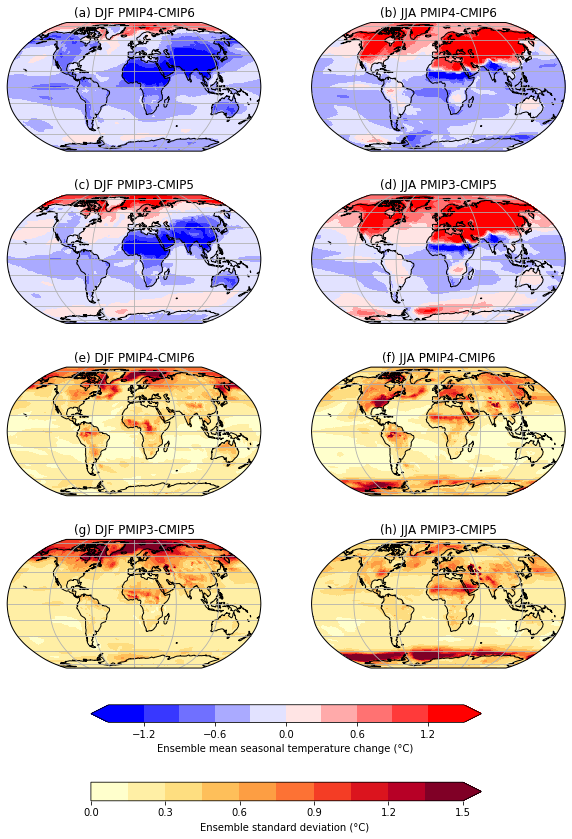

In [6]:
cmap1=plt.get_cmap('bwr')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim1=[-1.5,1.5]
bounds1 = np.linspace(-1.5, 1.5, 11)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
cmap2=plt.get_cmap('YlOrRd')
clim2=[0,1.5]
bounds2 = np.linspace(0, 1.5, 11)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()})
ax1=axs[0][0]
ax2=axs[1][0]

ax4=axs[2][0]
ax5=axs[3][0]
ax6=axs[0][1]
ax7=axs[1][1]

ax9=axs[2][1]
ax10=axs[3][1]
ax1.set_title('(a) DJF PMIP4-CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(tas_djf_ensemble_ave_v4, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax2.set_title('(c) DJF PMIP3-CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(tas_djf_ensemble_ave_v3, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)

ax4.set_title('(e) DJF PMIP4-CMIP6')
ax4.coastlines()
ax4.gridlines()
fig4=ax4.imshow(tas_djf_ensemble_std_v4, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax5.set_title('(g) DJF PMIP3-CMIP5')
ax5.coastlines()
ax5.gridlines()
fig5=ax5.imshow(tas_djf_ensemble_std_v3, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax6.set_title('(b) JJA PMIP4-CMIP6')
ax6.coastlines()
ax6.gridlines()
fig6=ax6.imshow(tas_jja_ensemble_ave_v4, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax7.set_title('(d) JJA PMIP3-CMIP5')
ax7.coastlines()
ax7.gridlines()
fig7=ax7.imshow(tas_jja_ensemble_ave_v3, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)

ax9.set_title('(f) JJA PMIP4-CMIP6')
ax9.coastlines()
ax9.gridlines()
fig9=ax9.imshow(tas_jja_ensemble_std_v4, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax10.set_title('(h) JJA PMIP3-CMIP5')
ax10.coastlines()
ax10.gridlines()
fig10=ax10.imshow(tas_jja_ensemble_std_v3, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)

cax2,kw2 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb1=plt.colorbar(fig3, cax=cax1, **kw1,extend='both')

cb1label='Ensemble mean seasonal temperature change (%sC) ' %chr(176)
cb2label='Ensemble standard deviation (%sC) ' %chr(176)
cb1.set_label(cb1label)
cb2.set_label(cb2label)
